# LC-MS: All Features Neg 


In [323]:
import pandas as pd
import numpy as np
import os
import openpyxl

# Visualizations 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from scipy.stats import zscore, entropy, f_oneway, kruskal
from sklearn.preprocessing import StandardScaler, LabelEncoder
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import pdist, squareform

from sklearn.ensemble import IsolationForest

%matplotlib inline

In [324]:
# set the directory 
os.chdir('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/Results')

In [325]:
# Define the color palette for the sample types
sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}


# 1. Load data

In [326]:
# order
samples = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/Order_34707_orderitem.csv')

# Extract the list of sample names
sample_names = samples['Sample Name'].tolist()

# Create a new dataframe 'sample_md' with selected column
sample_md = samples[['Sample Name']].copy()
# Split 'Sample Name' into new columns
sample_md[['sample_type', 'year', 'plot']] = sample_md['Sample Name'].str.split('_', expand=True)
sample_md.head()

,Sample Name,sample_type,year,plot
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14
1,PostMLF_2021_Plot9,PostMLF,2021,Plot9
2,PostMLF_2021_Plot15,PostMLF,2021,Plot15
3,PostMLF_2021_Plot12,PostMLF,2021,Plot12
4,PostMLF_2021_Plot17,PostMLF,2021,Plot17


In [327]:
# Get the raw data
file_path = "/home/lfloerl/cloud/lfloerl/Microterroir/LC-MS_data/FGCZ data/p32837_o34707_Lena_RPMetabolomics_ALL_features_NEG.xlsx"

# Read only the 'Area_Stats' sheet
df = pd.read_excel(file_path, sheet_name="Area_Stats")

# Fill empty 'Name' values with 'MW_' + corresponding 'Calc. MW' value
df['Name'] = df['Name'].fillna(df['Calc. MW'].apply(lambda x: f"MW_{x}" if pd.notna(x) else "MW_Unknown"))


## SUBSET TO NORMMALIZED SAMPLES 
# Identify 'Norm. Area' columns that correspond to samples in the list
matching_columns = [col for col in df.columns if any(sample in col for sample in sample_names)]
# Create a mapping to rename columns by extracting only the sample name
rename_dict = {col: next(sample for sample in sample_names if sample in col) for col in matching_columns}
# Select relevant columns and rename them
df = df[['Name'] + matching_columns].rename(columns=rename_dict)

# Set 'Name' as the index
df.set_index('Name', inplace=True)

df.head()

,Must_2023_Plot20,Must_2023_Plot19,Must_2023_Plot14,Must_2023_Plot17,Must_2023_Plot4,Must_2023_Plot9,Must_2023_Plot5,Must_2023_Plot12,Must_2023_Plot13,Must_2023_Plot15,...,PostMLF_2023_Plot4,PostMLF_2023_Plot15,PostMLF_2023_Plot5,PostMLF_2023_Plot20,PostMLF_2023_Plot17,PostMLF_2023_Plot13,PostMLF_2023_Plot14,PostMLF_2023_Plot19,PostMLF_2023_Plot9,PostMLF_2023_Plot12
Name,,,,,,,,,,,,,,,,,,,,,
MW_233.77126,5.921181e+08,5.705441e+08,5.737363e+08,5.723428e+08,5.894475e+08,5.828634e+08,5.733035e+08,5.717520e+08,5.676638e+08,5.671057e+08,...,6.474207e+08,5.992743e+08,6.773682e+08,5.999018e+08,5.883700e+08,5.724620e+08,6.512763e+08,6.370685e+08,6.499791e+08,6.037124e+08
MW_278.03993,1.212563e+08,1.687687e+08,2.039956e+08,1.393993e+08,1.238888e+08,1.776771e+08,1.769059e+08,1.105235e+08,1.526722e+08,9.426910e+07,...,2.492312e+06,8.154455e+06,4.539092e+06,6.589760e+06,3.553400e+07,2.071994e+06,2.666277e+07,3.576882e+06,4.478116e+06,2.081206e+06
MW_280.05565,3.717594e+04,5.638716e+04,4.217621e+04,5.859603e+04,5.693789e+04,5.112909e+04,6.681834e+04,5.020953e+04,4.524712e+04,5.664495e+04,...,1.279893e+07,3.110841e+06,4.971845e+06,2.087644e+06,4.367576e+07,9.953229e+05,9.456308e+07,2.175580e+06,1.007542e+07,2.216643e+06
MW_355.85102,1.474282e+08,1.453115e+08,1.435884e+08,1.504202e+08,1.378821e+08,1.286521e+08,1.518848e+08,1.433660e+08,1.534605e+08,1.436926e+08,...,1.662585e+08,1.417674e+08,1.735606e+08,1.436585e+08,1.546192e+08,1.525528e+08,1.483458e+08,1.699341e+08,1.625625e+08,1.627462e+08
MW_233.77107,6.883909e+06,1.081643e+06,8.892462e+05,9.026331e+05,9.401635e+05,8.966889e+05,1.009483e+06,6.014548e+06,4.733099e+06,1.329434e+06,...,4.795501e+07,1.039781e+07,7.085230e+07,2.404072e+07,5.432684e+06,2.595764e+07,1.423342e+07,1.378458e+07,8.109079e+07,1.489814e+07


In [328]:
## MERGE samples with metadata
df = df.T  # Transpose so samples are rows, features are columns
df.index.name = 'Sample Name'

# Merge metadata with metabolomics data
df_wMetadata = sample_md.merge(df, on='Sample Name')

df_wMetadata.head()

,Sample Name,sample_type,year,plot,MW_233.77126,MW_278.03993,MW_280.05565,MW_355.85102,MW_233.77107,MW_353.85419,...,Yersiniabactin,Zeamine II,Zeamine II,Zeamine II,Zearalenone,Zosterin,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,6.104596e+08,1.986450e+06,2.167232e+06,1.376786e+08,7.218171e+06,1.376786e+08,...,1.818351e+06,2.422564e+06,377432.647354,164039.301354,6.815362e+05,112371.220825,9.117716e+05,1.235786e+06,294124.470641,5.298362e+07
1,PostMLF_2021_Plot14,PostMLF,2021,Plot14,7.446954e+08,2.423256e+06,2.643791e+06,1.679532e+08,8.805396e+06,1.679532e+08,...,2.218193e+06,2.955269e+06,460427.439418,200110.393248,8.314012e+05,137080.864179,1.112264e+06,1.507527e+06,358800.378920,6.463435e+07
2,PostMLF_2021_Plot9,PostMLF,2021,Plot9,6.239606e+08,1.788991e+06,2.263174e+06,1.336121e+08,1.467524e+07,1.336121e+08,...,2.318776e+05,1.847888e+06,397760.089725,208824.454138,1.203493e+06,115854.044998,9.861356e+05,1.176052e+06,394940.090360,4.406049e+07
3,PostMLF_2021_Plot9,PostMLF,2021,Plot9,6.994691e+08,2.005486e+06,2.537051e+06,1.497811e+08,1.645117e+07,1.497811e+08,...,2.599382e+05,2.071510e+06,445894.975159,234095.318249,1.349134e+06,129874.107159,1.105473e+06,1.318371e+06,442733.713939,4.939247e+07
4,PostMLF_2021_Plot15,PostMLF,2021,Plot15,5.907132e+08,1.941881e+06,1.013067e+06,1.456115e+08,2.650140e+07,1.456115e+08,...,3.126963e+05,2.704389e+06,536258.586431,149738.476342,8.164301e+05,106780.948133,9.924499e+05,1.582798e+06,309829.677908,1.701082e+07


In [329]:
df_wMetadata.shape

(104, 5359)

** CHECK IF THIS IS VALID **

In [330]:
# Sum up duplicated Columns - CHECK if this is correct

metadata_columns = ['Sample Name', 'sample_type', 'year', 'plot']

# Separate metadata and data columns
metadata = df_wMetadata[metadata_columns]
data = df_wMetadata.drop(columns=metadata_columns)

# Sum up duplicate columns in the data part
data_summed = data.groupby(data.columns, axis=1).sum()

# Combine metadata and summed data
df_wMetadata = pd.concat([metadata, data_summed], axis=1)

df_wMetadata.shape

/scratch/lfloerl/tmpdata/ipykernel_2190937/401779589.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data_summed = data.groupby(data.columns, axis=1).sum()


(104, 5052)

In [331]:
df_wMetadata.head()

,Sample Name,sample_type,year,plot,(+)-abscisic acid beta-D-glucopyranosyl ester,(+)-applanatumol Z5,(+)-daeschol A,(+)-discoipyrrole A,(+)-pestalachloride E,(+/-)-Gingerol,...,tipifarnib,"trans,trans-Muconic acid",trans-Aconitic acid,trichloroacetate anion,tropatepine,vincofos,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
0,PostMLF_2021_Plot14,PostMLF,2021,Plot14,642503.181073,536896.166514,99617.701321,112571.665824,2.075353e+07,2.521520e+07,...,239009.983093,9.770792e+05,6.961293e+07,94049.938436,511774.850793,1.144833e+06,9.117716e+05,1.235786e+06,294124.470641,5.298362e+07
1,PostMLF_2021_Plot14,PostMLF,2021,Plot14,783785.124454,654955.868059,121522.935182,137325.385628,2.531708e+07,3.075984e+07,...,291566.602100,1.191932e+06,8.492033e+07,114730.860287,624310.551197,1.396573e+06,1.112264e+06,1.507527e+06,358800.378920,6.463435e+07
2,PostMLF_2021_Plot9,PostMLF,2021,Plot9,125921.032184,696596.794616,168119.006042,127425.732697,2.851008e+07,2.308717e+07,...,267322.130028,1.056770e+06,7.688034e+07,102411.174864,331961.126958,4.209660e+05,9.861356e+05,1.176052e+06,394940.090360,4.406049e+07
3,PostMLF_2021_Plot9,PostMLF,2021,Plot9,141159.349488,780895.364958,188463.905654,142846.141138,3.196022e+07,2.588107e+07,...,299672.082764,1.184655e+06,8.618401e+07,114804.449847,372133.359487,4.719091e+05,1.105473e+06,1.318371e+06,442733.713939,4.939247e+07
4,PostMLF_2021_Plot15,PostMLF,2021,Plot15,301718.162373,488943.547898,95206.813702,129749.547114,2.321104e+07,2.227090e+07,...,270956.282087,1.063536e+06,1.033673e+08,91401.430851,571293.202247,5.690960e+05,9.924499e+05,1.582798e+06,309829.677908,1.701082e+07


### Alpha Diversity 
> check before normalizing 

#### Shannon Entropy

In [332]:
# Shannon entropy calculation
def shannon_entropy(values):
    """Calculate Shannon entropy for a given array of values."""
    # Normalize the values to get probabilities
    value_counts = values.value_counts(normalize=True)
    return entropy(value_counts)

# Function to apply Shannon entropy to the dataframe
def shannon_diversity_df(df):
    """Calculate Shannon Diversity for each column in a DataFrame."""
    shannon_diversity_values = {}
    for column in df.columns:
        shannon_diversity_values[column] = shannon_entropy(df[column])
    return pd.Series(shannon_diversity_values)

In [333]:
 # Apply Shannon entropy calculation to the collapsed data
shannon_diversity_results = df_wMetadata.apply(shannon_entropy, axis=1)

# Add the Shannon diversity values to a new dataframe with 'Sample Type' and 'Year'
shannon_diversity_df = pd.DataFrame({
    'Sample Type': df_wMetadata['sample_type'],  # Assuming 'sample_type' is a column
    'Year': df_wMetadata['year'],  # Assuming 'year' is a column
    'Shannon Diversity': shannon_diversity_results
})

In [334]:
# Group by 'Year' and 'Sample Type' for Shannon index
shannon_grouped = shannon_diversity_df.groupby(['Year', 'Sample Type'])['Shannon Diversity']

# Extract values for each group
group_postMLF_2023_shannon = shannon_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_shannon = shannon_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_shannon = shannon_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('SHANNON postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2022_shannon)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2023_shannon, group_postMLF_2021_shannon)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)

anova_result = f_oneway(group_postMLF_2022_shannon, group_postMLF_2021_shannon)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

SHANNON postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 4.550531795894962e-05
ANOVA 2023 vs 2021 p-value: 0.6714610410408153
ANOVA 2022 vs 2021 p-value: 0.5174901323201555


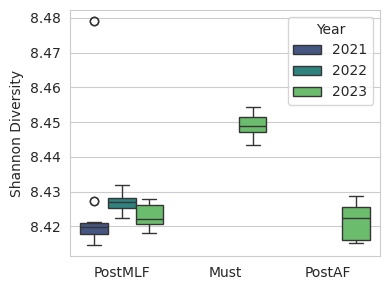

In [335]:
# Plot box plots
plt.figure(figsize=(4, 3))
sns.boxplot(data=shannon_diversity_df, x='Sample Type', y='Shannon Diversity', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Shannon Diversity')
plt.legend(title='Year')
plt.tight_layout() 
plt.show()

#### Richness

In [336]:
def richness(df):
    """Calculate richness (number of unique values) for each row in the DataFrame."""
    return df.apply(lambda x: x.nunique(), axis=1)

In [337]:
# Calculate richness for each sample (row)
richness_values = richness(df_wMetadata.iloc[:, 3:])

# Create a DataFrame with richness values
richness_df = pd.DataFrame(richness_values, columns=['Richness']).reset_index()

# Extract 'Sample Type' and 'Year' from the index or metadata columns
richness_df['Sample Type'] = df_wMetadata['sample_type'].values
richness_df['Year'] = df_wMetadata['year'].values

In [338]:
richness_grouped = richness_df.groupby(['Year', 'Sample Type'])['Richness']

# Extract values for each group
group_postMLF_2023_values = richness_grouped.get_group(('2023', 'PostMLF'))
group_postMLF_2022_values = richness_grouped.get_group(('2022', 'PostMLF'))
group_postMLF_2021_values = richness_grouped.get_group(('2021', 'PostMLF'))

# Perform ANOVA tests
print('RICHNESS postMLF ANOVAS')
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2022_values)
print("ANOVA 2023 vs 2022 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2023_values, group_postMLF_2021_values)
print("ANOVA 2023 vs 2021 p-value:", anova_result.pvalue)
anova_result = f_oneway(group_postMLF_2022_values, group_postMLF_2021_values)
print("ANOVA 2022 vs 2021 p-value:", anova_result.pvalue)

RICHNESS postMLF ANOVAS
ANOVA 2023 vs 2022 p-value: 8.641697704039196e-05
ANOVA 2023 vs 2021 p-value: 0.5618006554498527
ANOVA 2022 vs 2021 p-value: 0.6283400460626097


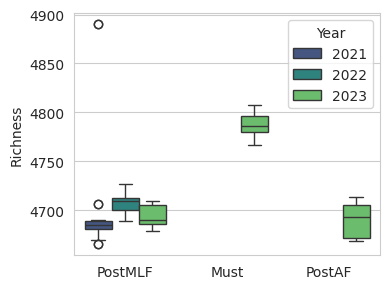

In [339]:
# Plot box plots
sns.set_style(style="whitegrid")
plt.figure(figsize=(4, 3))
sns.boxplot(data=richness_df, x='Sample Type', y='Richness', hue='Year', dodge=True, palette="viridis")
plt.title('')
plt.xlabel('')
plt.ylabel('Richness')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

### Normalize & Transform Data

1. Log Transformation to reduce skewness.
2. Pareto/Auto-scaling (Z-score normalization) for better comparison.

In [340]:
df_wMetadata.iloc[:, 4:] = np.log1p(df_wMetadata.iloc[:, 4:])  # Log transform
scaler = StandardScaler()
df_wMetadata.iloc[:, 4:] = scaler.fit_transform(df_wMetadata.iloc[:, 4:])

df_wMetadata.set_index('Sample Name', inplace=True)

In [341]:
df_wMetadata.shape

(104, 5051)

### Remove outliers

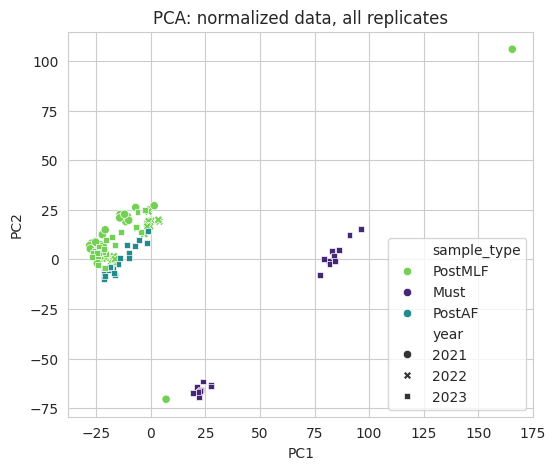

In [342]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata.iloc[:, 3:])

df_pca = df_wMetadata[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

sample_type_palette = {'Must': '#482677FF', 'PostAF': '#238A8DFF','PostMLF': '#74D055FF'}

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data, all replicates')
plt.show()


The Post-MLF 2021 samples appear to be outliers - we apply an Isolation Forest to clear this up

> Alternative: Apply Isolation Forest on PCA Scores? 

In [343]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(df_wMetadata.iloc[:, 4:])  # Fit on normalized data

# Remove outliers (label = -1)
df_wMetadata_cleaned = df_wMetadata[outlier_labels == 1]
df_wMetadata_cleaned.shape

(98, 5051)

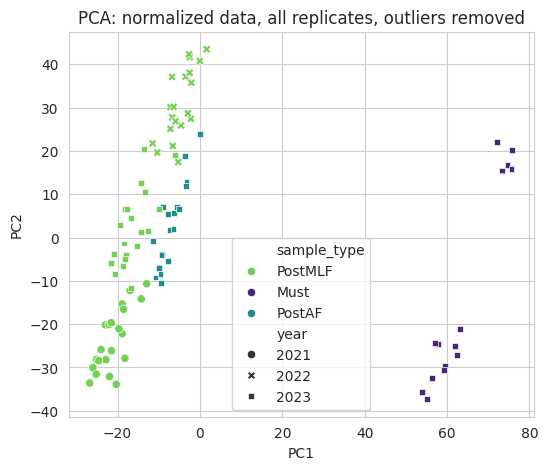

In [344]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata_cleaned.iloc[:, 3:])

df_pca = df_wMetadata_cleaned[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette = sample_type_palette)
plt.title('PCA: normalized data, all replicates, outliers removed')
plt.show()


### Collapse Replicates

In [345]:
# Group by the index (sample name) and calculate the median for numerical columns
df_median = df_wMetadata_cleaned.iloc[:, 3:].groupby(df_wMetadata_cleaned.index).median()

# If you want to retain the metadata columns (which are categorical), you can take the first occurrence for each sample
df_metadata = df_wMetadata_cleaned.groupby(df_wMetadata_cleaned.index).first()[['sample_type', 'year', 'plot']]

# Merge the median values with the metadata
df_wMetadata_cleaned_collapsed = df_metadata.join(df_median)

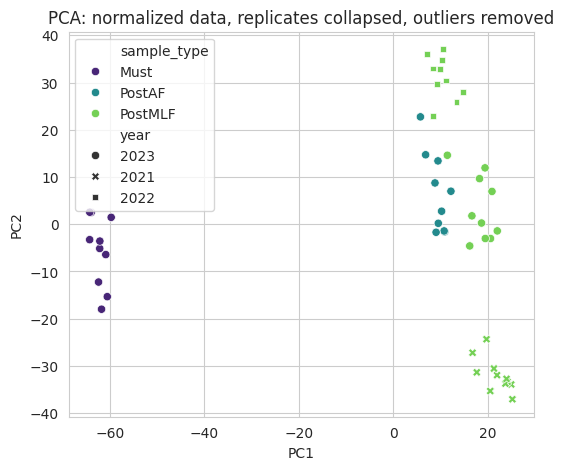

In [346]:
# Perform PCA
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(df_wMetadata_cleaned_collapsed.iloc[:, 3:])

# Create a DataFrame for the PCA results
df_pca = df_wMetadata_cleaned_collapsed[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

# Plot PCA with custom color palette for sample type
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='sample_type', style='year', palette=sample_type_palette)
plt.title('PCA: normalized data, replicates collapsed, outliers removed')
plt.show()

In [347]:
# save
df_wMetadata_cleaned_collapsed.to_csv('Neg_All_OutlierRemoved_Collapsed.csv')

# 2. Compare PostMLF 

In [348]:
postMLF_df = df_wMetadata_cleaned_collapsed[df_wMetadata_cleaned_collapsed['sample_type'] == 'PostMLF']

### Clustermap

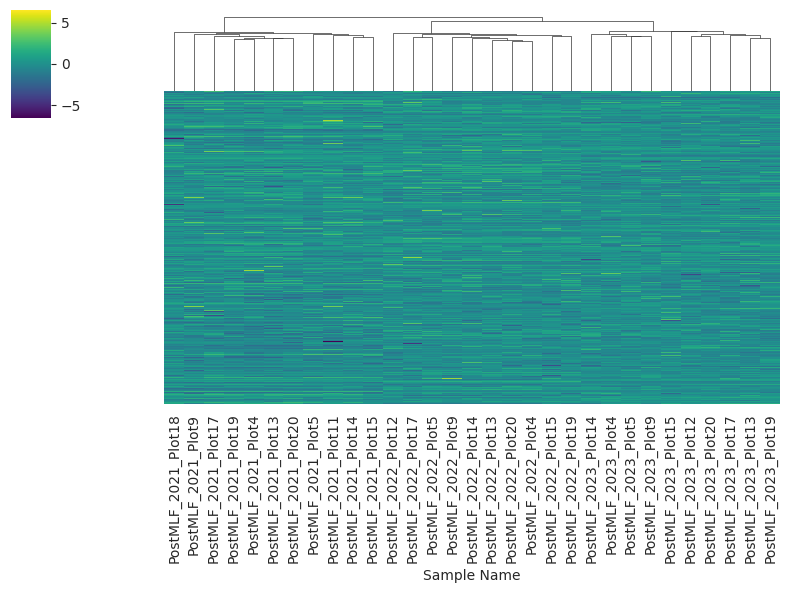

In [349]:
clustermap_df = postMLF_df.iloc[:, 3:].T

sns.clustermap(clustermap_df, cmap="viridis", col_cluster=True, row_cluster=False, xticklabels=True, yticklabels=False, figsize=(8, 6))
plt.show()

### PCA plot

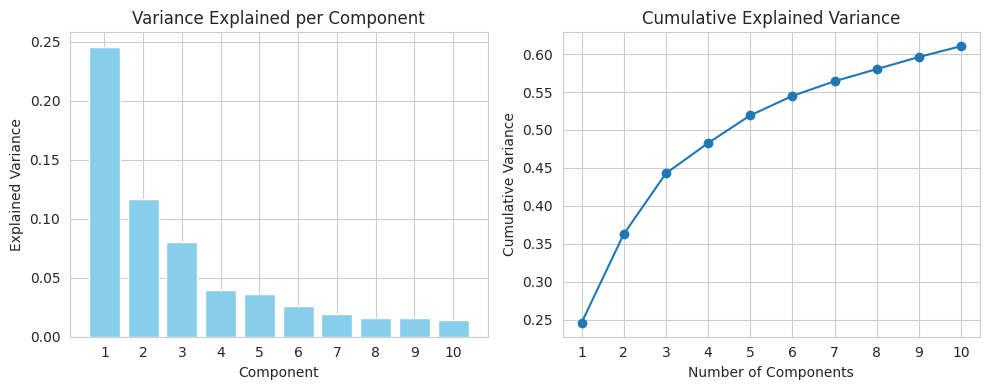

In [350]:
# Instantiate PCA with the max number of components to test
n_components = 10
pca = PCA(n_components=n_components)

# Fit the PCA to your data
pca.fit(df_wMetadata_cleaned_collapsed.iloc[:, 3:])

# Create subplots for the explained variance and cumulative variance plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot explained variance ratio (variance per component)
axes[0].bar(range(1, n_components + 1), pca.explained_variance_ratio_, color='skyblue')
axes[0].set_title('Variance Explained per Component')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Explained Variance')
axes[0].set_xticks(range(1, n_components + 1))
axes[0].grid(True)

# Plot cumulative explained variance (elbow plot)
axes[1].plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
axes[1].set_title('Cumulative Explained Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].grid(True)

# Adjust layout to ensure the plots are displayed nicely
plt.tight_layout()
plt.show()

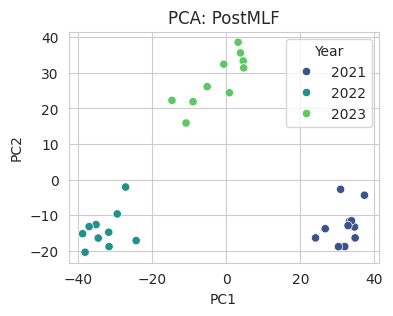

In [351]:
pca = PCA(n_components=2)
pca_scores = pca.fit_transform(postMLF_df.iloc[:, 3:])

df_pca = postMLF_df[['sample_type', 'year', 'plot']].copy()
df_pca['PC1'], df_pca['PC2'] = pca_scores[:, 0], pca_scores[:, 1]

plt.figure(figsize=(4,3))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='year',  palette='viridis')
plt.title('PCA: PostMLF')
plt.legend(title='Year')
plt.show()


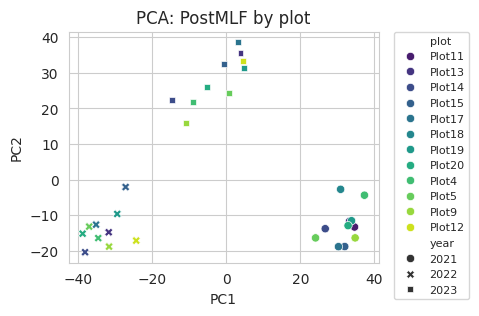

In [352]:
plt.figure(figsize=(4,3))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='plot', style='year', palette='viridis')
plt.title('PCA: PostMLF by plot')
plt.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=8)
plt.show()



### Are some plot reliably more similar to each other? 

In [353]:
# Identify plots that are present in every year
plots_per_year = postMLF_df.groupby("year")["plot"].unique().tolist()
common_plots = set(plots_per_year[0]).intersection(*plots_per_year[1:])  # Find common plots

# Subset the dataframe to only include common plots
df_filtered = postMLF_df[postMLF_df["plot"].isin(common_plots)].copy()

In [354]:
# Select only the metabolomics data (excluding metadata columns)
metadata_cols = ["sample_type", "year", "plot"]
df_metabolites = df_filtered.drop(columns=metadata_cols)
df_metabolites.shape

(27, 5048)

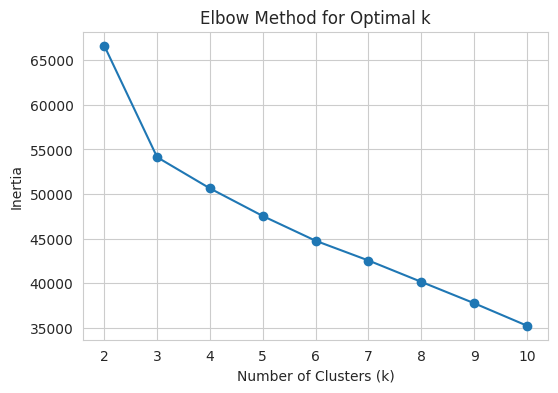

In [355]:
# Determine the number of clusters (k) using the Elbow Method
def optimal_k_elbow(data, max_k=10):
    inertia = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(2, max_k + 1), inertia, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.title("Elbow Method for Optimal k")
    plt.show()
# Run the elbow method to determine k
optimal_k_elbow(df_metabolites)

In [356]:
# Define the number of clusters
k_clusters = 3

# Ensure 'cluster' column exists as an integer type
df_filtered["cluster"] = -1  

# Apply K-means clustering for each year
for year in df_filtered["year"].unique():
    df_year = df_filtered[df_filtered["year"] == year]
    
    # Extract metabolite data
    df_year_metabolites = df_year.drop(columns=metadata_cols)
    
    # Handle missing values (optional: fill or drop)
    df_year_metabolites = df_year_metabolites.fillna(df_year_metabolites.median())

    # Fit K-means and assign cluster labels
    kmeans = KMeans(n_clusters=k_clusters, random_state=42, n_init=10)
    df_filtered.loc[df_year.index, "cluster"] = kmeans.fit_predict(df_year_metabolites).astype(int)


In [357]:
# Pivot table to see cluster assignments across years
contingency_table = pd.crosstab(df_filtered["plot"], [df_filtered["year"], df_filtered["cluster"]])
print("\nContingency Table:\n", contingency_table)



Contingency Table:
 year    2021       2022       2023      
cluster    0  1  2    0  1  2    0  1  2
plot                                    
Plot13     0  1  0    1  0  0    1  0  0
Plot14     0  0  1    1  0  0    0  1  0
Plot15     0  0  1    0  0  1    0  0  1
Plot17     0  1  0    0  1  0    1  0  0
Plot19     0  1  0    1  0  0    1  0  0
Plot20     0  1  0    1  0  0    0  1  0
Plot4      0  1  0    1  0  0    0  1  0
Plot5      1  0  0    0  1  0    0  1  0
Plot9      0  0  1    1  0  0    0  1  0


In [358]:
from itertools import combinations

# Get sorted unique years
years = sorted(df_filtered["year"].unique())

# Compute ARI for all pairs of years
for year1, year2 in combinations(years, 2):
    year1_labels = df_filtered[df_filtered["year"] == year1]["cluster"]
    year2_labels = df_filtered[df_filtered["year"] == year2]["cluster"]
    
    # Compute ARI
    if len(year1_labels) == len(year2_labels):
        ari_score = adjusted_rand_score(year1_labels, year2_labels)
        print(f"\nAdjusted Rand Index (ARI) between {year1} and {year2}: {ari_score:.4f}")
    else:
        print(f"\nError: Mismatch in the number of plots between {year1} and {year2}.")



Adjusted Rand Index (ARI) between 2021 and 2022: 0.1401

Adjusted Rand Index (ARI) between 2021 and 2023: 0.0368

Adjusted Rand Index (ARI) between 2022 and 2023: 0.1401


In [359]:
df_filtered.head()

,sample_type,year,plot,(+)-abscisic acid beta-D-glucopyranosyl ester,(+)-applanatumol Z5,(+)-daeschol A,(+)-discoipyrrole A,(+)-pestalachloride E,(+/-)-Gingerol,(+/-)12(13)-DiHOME,...,"trans,trans-Muconic acid",trans-Aconitic acid,trichloroacetate anion,tropatepine,vincofos,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid,cluster
Sample Name,,,,,,,,,,,,,,,,,,,,,
PostMLF_2021_Plot13,PostMLF,2021,Plot13,-1.350953,1.641052,-0.655945,0.168690,0.252778,-0.377386,1.251320,...,-0.503609,0.275723,-0.729478,1.141318,-0.377132,-0.609557,-0.673526,-0.632344,0.648074,1
PostMLF_2021_Plot14,PostMLF,2021,Plot14,-0.388632,0.425933,-1.421040,-1.372476,0.592484,0.263022,0.316829,...,-0.576541,0.140682,-0.308184,-0.193856,0.135363,-0.726509,-0.400858,-0.573146,0.537515,2
PostMLF_2021_Plot15,PostMLF,2021,Plot15,-1.407931,0.316462,-1.534628,-1.228688,0.656509,-0.462388,1.075575,...,-0.514583,0.647230,-0.525039,-0.106712,-0.696969,-0.627155,-0.159765,-0.543933,-0.469339,2
PostMLF_2021_Plot17,PostMLF,2021,Plot17,-2.143912,2.471040,-1.049394,-0.666723,0.134827,-0.158365,1.228237,...,0.773166,0.366799,-0.150117,0.227451,-0.952276,0.380556,-0.582573,-0.559662,0.774885,1
PostMLF_2021_Plot19,PostMLF,2021,Plot19,-1.894400,0.186959,-1.258717,-1.302339,0.274760,-0.018187,1.299171,...,-0.677159,0.366142,-0.543032,1.032500,-1.216314,-0.887859,-0.534319,-0.505225,0.708950,1


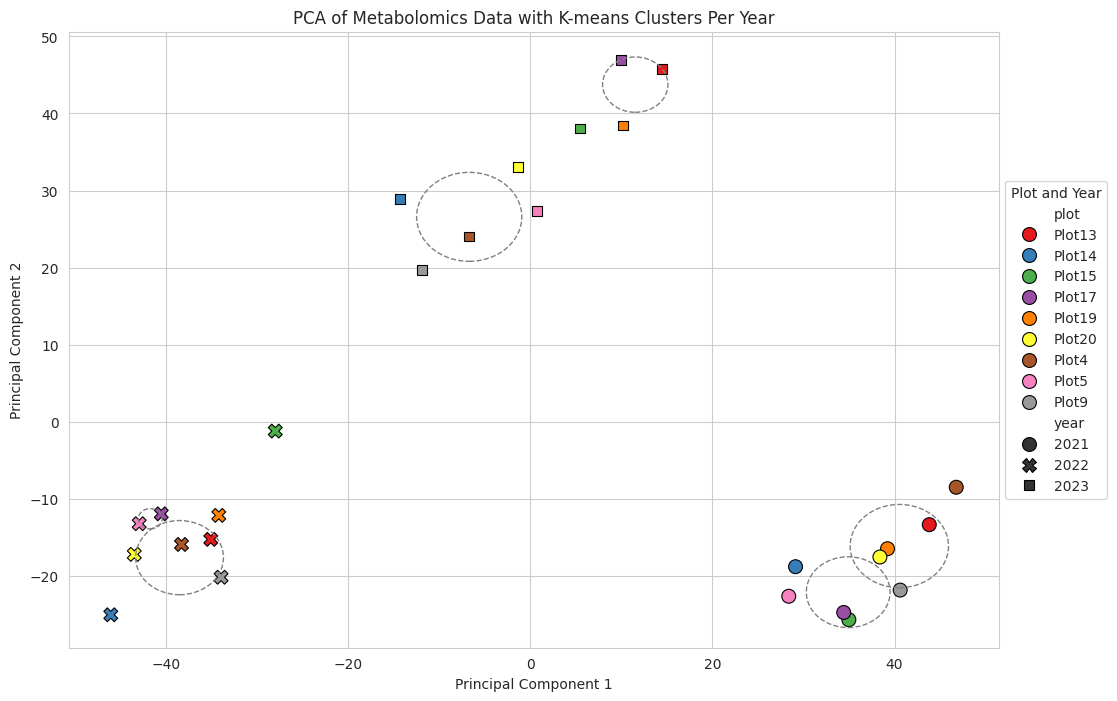

In [363]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the metabolomics data (excluding metadata columns)
metadata_cols = ["sample_type", "year", "plot"]
df_metabolites = df_filtered.drop(columns=metadata_cols)

# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_metabolites)

# Apply PCA (2 components for visualization)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Add PCA components to the original dataframe for visualization
df_filtered["PCA1"] = pca_result[:, 0]
df_filtered["PCA2"] = pca_result[:, 1]

# Ensure the 'cluster' column is categorical for correct plotting
df_filtered["cluster"] = df_filtered["cluster"].astype("category")

# Create a PCA plot colored by plot, and shape by year
plt.figure(figsize=(12, 8))

# Scatter plot with colors by plot, and shapes by year
sns.scatterplot(data=df_filtered, x="PCA1", y="PCA2", hue="plot", style="year", palette="Set1", s=100, edgecolor="k")

# Circle the clusters per year
for year in df_filtered["year"].unique():
    for cluster in df_filtered["cluster"].cat.categories:  # Loop through categorical clusters
        cluster_data = df_filtered[(df_filtered["year"] == year) & (df_filtered["cluster"] == cluster)]
        mean_x = cluster_data["PCA1"].mean()
        mean_y = cluster_data["PCA2"].mean()
        std_dev = cluster_data[["PCA1", "PCA2"]].std().mean()
            
        # Draw a circle around the cluster
        plt.gca().add_patch(plt.Circle((mean_x, mean_y), radius=std_dev, color="gray", fill=False, linestyle="--"))

plt.title("PCA of Metabolomics Data with K-means Clusters Per Year")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Move legend to the right side of the plot
plt.legend(title="Plot and Year", loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()


# 3. Within 2023

In [161]:
duplicates = df_wMetadata_cleaned_collapsed.columns[df_wMetadata_cleaned_collapsed.columns.duplicated()]
print("Duplicate column names:", list(duplicates))


Duplicate column names: []


In [162]:
all_2023_df = df_wMetadata_cleaned_collapsed[df_wMetadata_cleaned_collapsed['year'] == '2023']
all_2023_df.head()

,sample_type,year,plot,(+)-abscisic acid beta-D-glucopyranosyl ester,(+)-applanatumol Z5,(+)-daeschol A,(+)-discoipyrrole A,(+)-pestalachloride E,(+/-)-Gingerol,(+/-)12(13)-DiHOME,...,tipifarnib,"trans,trans-Muconic acid",trans-Aconitic acid,trichloroacetate anion,tropatepine,vincofos,{3-Oxo-2-[(2E)-5-sulfo-2-penten-1-yl]cyclopentyl}acetic acid,"α,α-Trehalose",α-hydroxyacetovanillone,β-D-Glucopyranuronic acid
Sample Name,,,,,,,,,,,,,,,,,,,,,
Must_2023_Plot12,Must,2023,Plot12,-0.155350,-1.014494,-0.430895,-1.327786,-0.826518,-0.505228,-0.834117,...,0.637739,1.828666,-0.853276,-0.147364,-1.091419,-1.401792,-0.921935,1.410482,-0.688983,-1.110164
Must_2023_Plot13,Must,2023,Plot13,0.495861,-0.862561,1.276809,1.215841,-1.826256,0.626358,-0.497241,...,1.239380,2.879481,0.601904,3.577556,-0.806708,-0.819825,0.051646,1.747038,-0.450846,-0.595616
Must_2023_Plot14,Must,2023,Plot14,1.817117,-0.764533,2.098452,0.716058,-1.183568,0.472756,-0.508563,...,3.463792,2.049461,0.310311,0.483073,-0.834727,-0.881181,2.349319,2.021031,-0.362133,-2.167706
Must_2023_Plot15,Must,2023,Plot15,-0.045787,-1.118382,0.245457,-0.371378,-1.781272,-0.465736,-0.758775,...,1.851388,0.384085,0.081103,-0.287992,-1.133979,-1.284648,0.938870,1.576165,-0.619604,-1.522121
Must_2023_Plot17,Must,2023,Plot17,0.185450,-0.840140,1.268717,0.329058,-1.671512,0.641566,-0.568639,...,1.321419,0.578870,-0.404175,0.463594,-0.828457,-0.749925,0.841548,1.985341,-0.421286,-0.650915


In [163]:
# Separate features and target
X = all_2023_df.drop(['sample_type', 'year', 'plot'], axis=1)
y = all_2023_df['sample_type']

# Create a LabelEncoder object
le = LabelEncoder()
# Fit and transform the 'sample_type' column
y_encoded = le.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform OPLS-DA
pls = PLSRegression(n_components=2, scale=False)
X_opls = pls.fit_transform(X_scaled, y_encoded)[0]




In [164]:
# Calculate VIP scores
t = pls.x_scores_
w = pls.x_weights_
q = pls.y_loadings_

p, h = t.shape
vips = np.zeros((X.shape[1],))
s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
total_s = np.sum(s)
for i in range(X.shape[1]):
    weight = np.array([(w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h)])
    vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

# Get top discriminatory metabolites
top_n = 30  # Number of top metabolites to select
top_metabolites = X.columns[np.argsort(vips)[::-1][:top_n]]

/scratch/lfloerl/tmpdata/ipykernel_2190937/550795015.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vips[i] = np.sqrt(p*(s.T @ weight)/total_s)


In [165]:
# Perform one-way ANOVA
p_values = []
for metabolite in top_metabolites:
    groups = [group[metabolite].values for name, group in all_2023_df.groupby('sample_type')]
    f_value, p_value = f_oneway(*groups)
    p_values.append(p_value)

# Create a dataframe with top metabolites and their p-values
top_metabolites_df = pd.DataFrame({'Metabolite': top_metabolites, 'VIP': vips[np.argsort(vips)[::-1][:top_n]], 'p_value': p_values})
top_metabolites_df = top_metabolites_df.sort_values('VIP', ascending=False)

top_metabolites_df

,Metabolite,VIP,p_value
0,MW_234.99102,0.143844,1.406827e-21
1,MW_291.95202,0.143242,2.931776e-16
2,MW_433.0197,0.142675,1.004037e-16
3,UX9347500,0.142210,1.741252e-18
4,Gentisic acid,0.142000,1.146141e-16
5,(-)threo-iso(homo)3citrate,0.141297,1.645651e-15
6,α-hydroxyacetovanillone,0.141017,2.388158e-18
7,L-Ascorbic acid 2-sulfate,0.140195,3.350091e-15
8,2-O-ETHYL ASCORBIC ACID,0.139963,2.920913e-20
9,MW_234.03195,0.139863,6.939343e-16


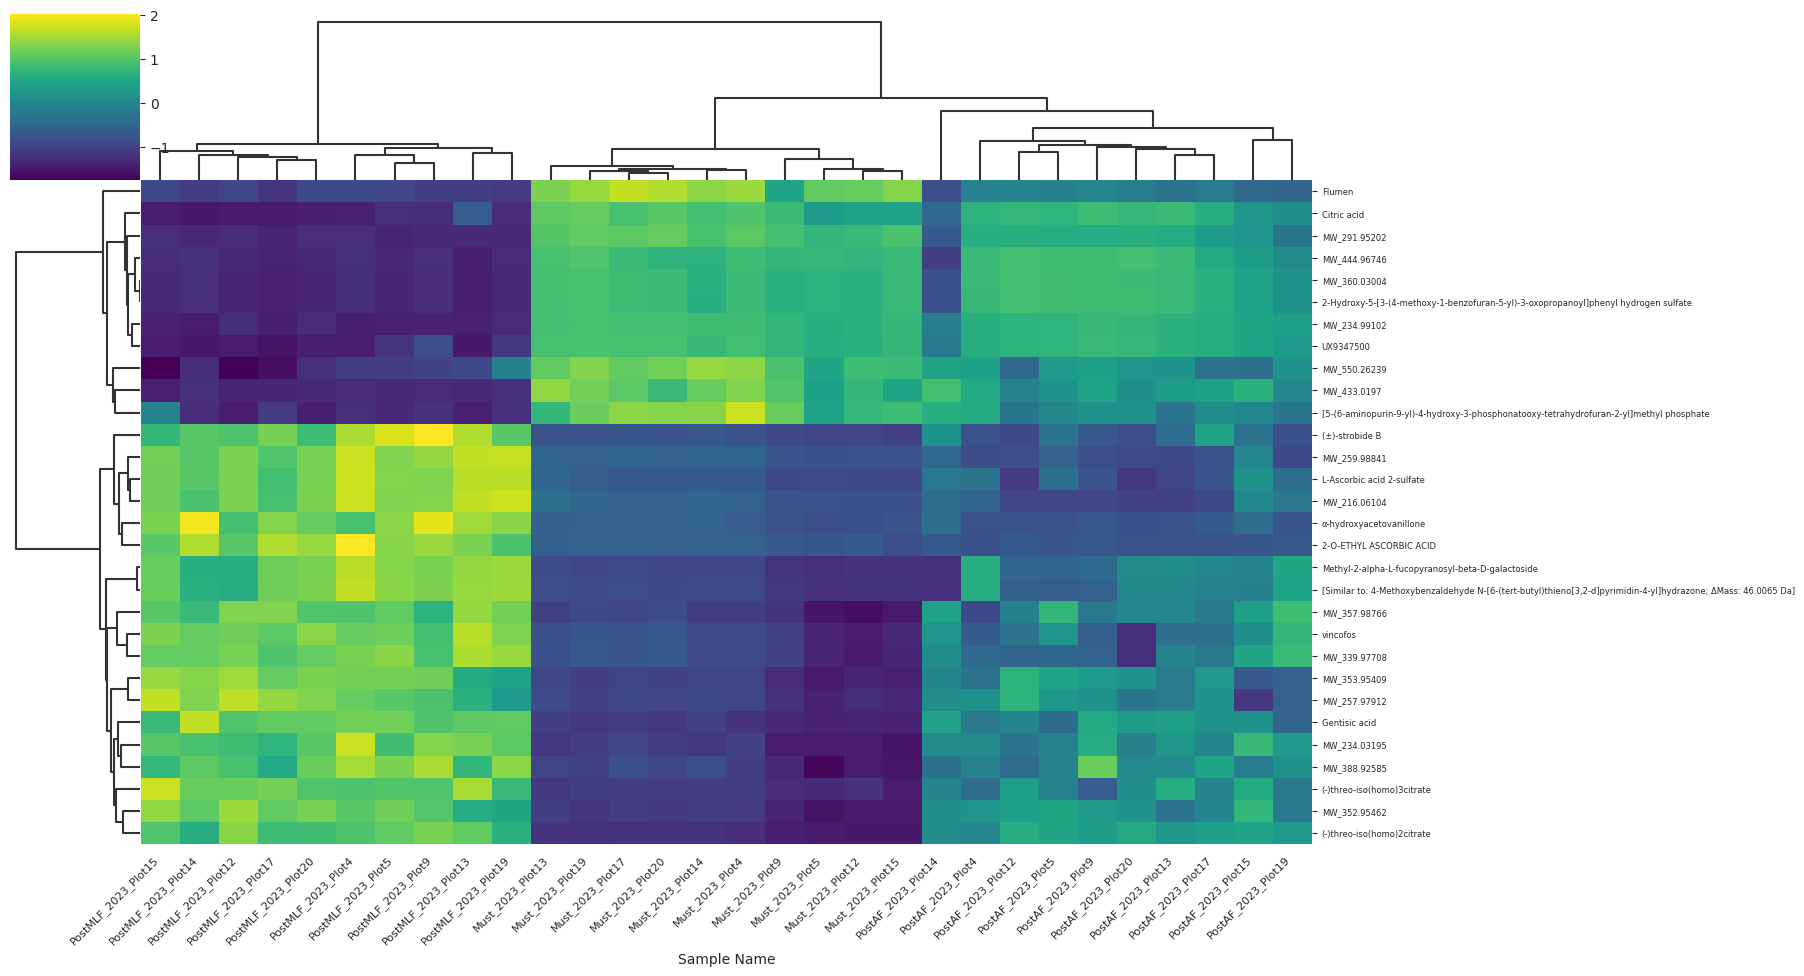

In [176]:
# Create heatmap data
heatmap_data = X[top_metabolites].copy()
heatmap_data = (heatmap_data - heatmap_data.mean()) / heatmap_data.std()  # Z-score normalization

# Transpose the heatmap data
heatmap_data_transposed = heatmap_data.T

# Use in clustermap
g = sns.clustermap(heatmap_data_transposed, 
                   cmap='viridis', 
                   yticklabels=True, 
                   xticklabels=True, 
                   row_cluster=True,
                   col_cluster=True,
                   dendrogram_ratio=(0.1, 0.2),
                   cbar_pos=(1.8, .3, .03, .4),
                   tree_kws={'linewidths': 1.5},
                   figsize=(14, 10))

# Rotate x-axis labels and reduce font size
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# Reduce y-axis (metabolite) label font size
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=6)

# Adjust the layout
g.fig.subplots_adjust(top=0.93, bottom=0.1, left=0.05, right=0.98)

plt.show()
